# Introduction

The main idea is to analyze the passes in & out the area.

The first step is to find wich passes are in & out, because in the data there are only coordintes of where the players where located

# Libraries

In [1]:
#!pip install mplsoccer
import pandas as pd
import numpy as np
import seaborn as sns
from kloppy.domain import PitchDimensions
import kloppy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import json
import dask.dataframe as dd
from mplsoccer.pitch import Pitch
from sklearn.neighbors import NearestNeighbors

C:\Users\const\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Read Data

Read data from Oakland UCL 2023

In [2]:
data = pd.read_parquet('USLChampionship_2023.parquet')

In [3]:
def coord_x(arr):
    if arr is not None and len(arr) > 0:
        return arr[0]
    else:
        return None

In [4]:
def coord_y(arr):
    if arr is not None and len(arr) > 0:
        return arr[1]
    else:
        return None

In [5]:
def preprocess(df):
    df['location_x'] = df.location.apply(coord_x)
    df['location_y'] = df.location.apply(coord_y)
    df['location_x_destiny'] = df.pass_end_location.apply(coord_x)
    df['location_y_destiny'] = df.pass_end_location.apply(coord_y)
    df['big_area_origin'] = np.where(df.location_x is None, 0,
                            np.where(((df.location_x<=20) & (df.location_x>=0) & (df.location_y >= 20) & (df.location_y<=60)) |
                                     ((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60)),1,0))
    df['big_area_destiny'] = np.where(df.location_x_destiny is None, 0,
                            np.where(((df.location_x_destiny<=20) & (df.location_x_destiny>=0) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)) |
                                     ((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)),1,0))
    matches = df[['match_id', 'team']].drop_duplicates()
    passes = df[df['type'] == 'Pass'].dropna(axis = 1, how = 'all')
    passes = passes[(passes['pass_type'].isin(['Recovery', 'Interception'])) | (passes['pass_type'].isnull())].reset_index(drop = True)
    passes = passes.merge(matches, on='match_id', suffixes=('', '_opp'), how='left')
    passes = passes[passes['team'] != passes['team_opp']].reset_index(drop = True)
    passes.rename(columns={'team_opp': 'opp_team'}, inplace=True)
    passes['pass_outcome'] = passes['pass_outcome'].fillna('Complete')
    return passes

In [6]:
data = preprocess(data)

In [7]:
def preprocess2(df):
    matches = df[['match_id', 'team']].drop_duplicates()
    passes = df[df['type'] == 'Pass'].dropna(axis = 1, how = 'all')
    passes = passes[(passes['pass_type'].isin(['Recovery', 'Interception'])) | (passes['pass_type'].isnull())].reset_index(drop = True)
    passes[['location_x' , 'location_y']] = pd.DataFrame(passes['location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
    passes[['location_x_destiny' , 'location_y_destiny']] = pd.DataFrame(passes['pass_end_location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
    passes = passes.merge(matches, on='match_id', suffixes=('', '_opp'), how='left')
    passes = passes[passes['team'] != passes['team_opp']].reset_index(drop = True)
    passes.rename(columns={'team_opp': 'opp_team'}, inplace=True)
    passes['pass_outcome'] = passes['pass_outcome'].fillna('Complete')
    return passes

data = preprocess(data)
data['location_x'] = data['location_x'].astype(float).replace(120, 119.999)
data['location_y'] = data['location_y'].astype(float).replace(80, 79.999)
data['location_x_destiny'] = data['location_x_destiny'].astype(float).replace(120, 119.999)
data['location_y_destiny'] = data['location_y_destiny'].astype(float).replace(80, 79.999)

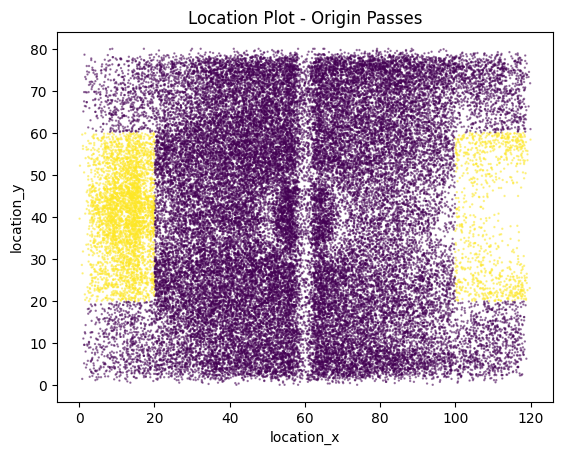

In [8]:
plt.scatter(data['location_x'].head(50000), data['location_y'].head(50000), alpha = 0.5, c = data['big_area_origin'].head(50000), s = 0.5)

# Add labels and title
plt.xlabel('location_x')
plt.ylabel('location_y')
plt.title('Location Plot - Origin Passes')

# Show the plot
plt.show()

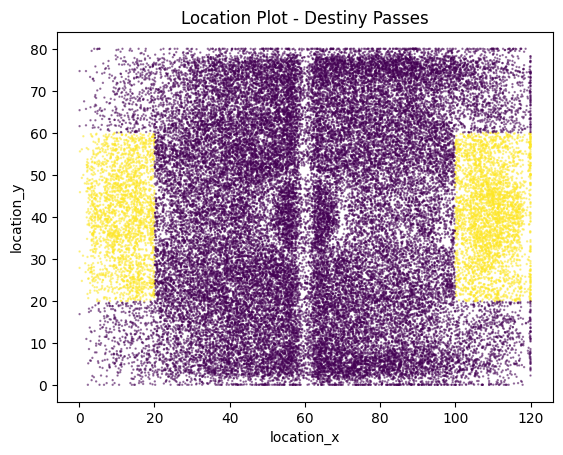

In [9]:
plt.scatter(data['location_x_destiny'].head(50000), data['location_y_destiny'].head(50000), alpha = 0.5, c = data['big_area_destiny'].head(50000), s = 0.5)

# Add labels and title
plt.xlabel('location_x')
plt.ylabel('location_y')
plt.title('Location Plot - Destiny Passes')

# Show the plot
plt.show()


# Court Function

In [10]:
def plot_soccer_court():
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the figure size and axis limits
    fig.set_size_inches(7, 5)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)

    # Plot the outer boundary of the soccer court
    ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color='black')
    
    # Center line
    ax.plot([60, 60], [0, 80], color='black')
    
    # Middle circle
    ax.add_patch(plt.Circle((60, 40), 9, color='black', fill=False))
    
    # Penalty areas
    ax.plot([0, 20], [20, 20], color='black')
    ax.plot([0, 20], [60, 60], color='black')
    ax.plot([20, 20], [20, 60], color='black')
    
    ax.plot([100, 120], [20, 20], color='black')
    ax.plot([100, 120], [60, 60], color='black')
    ax.plot([100, 100], [20, 60], color='black')
     
    
    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Remove the axis labels and ticks
    ax.axis('off')

# Pass Clustering

For this project, we will focus only in passes from out to inside the box.

So, the idea is to filter first only these kind of passes.

The clusters will be divided in:
 - Ground & Low
 - High

So, will be needed to fit 2 clustering algorigthms.

The steps for this will be:

 - Create a function to clean the data, and keep only passes from outside to inside the box, and the type of passes needed.
 - Create to function to fit a k-means, with the viz of the elbow plot, and the number of clusters.

The clusters will be viz with the centroid of each cluster.

The centroid will be defined as the average of the x & y coords for origin and destiny for each group.


## Clean data function

In [11]:
def clean_data(df,pass_type): # pass types can be 'high' or 'low'. And low will include ground
    
    # Keep passes with known place
    df = df[df.location_x.notnull()]
    
    # Keep passes only from outside to inside the box
    df = df[((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60))]
    df = df[~((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60))]
    
    # Keep only the type of passes requiered
    pt = np.where(pass_type == 'high', ['High Pass'], ['Low Pass','Ground Pass'])
    df = df[df.pass_height.isin(pt)]
    
    return df

## Cluster viz function

Function to viz clusters and elbow for a pass type

In [62]:
dataC = clean_data(data,'Low')

In [63]:
clusterFeatures_num = ['location_x','location_y',
                       'location_x_destiny','location_y_destiny','pass_length']

In [64]:
dataC_features = dataC[clusterFeatures_num]
dataC_features = dataC_features.dropna()

In [65]:
gmm = GaussianMixture(n_components=20)

In [66]:
gmm.fit(dataC_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


GaussianMixture(n_components=20)

In [67]:
dataC_features['cluster'] = gmm.predict(dataC_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


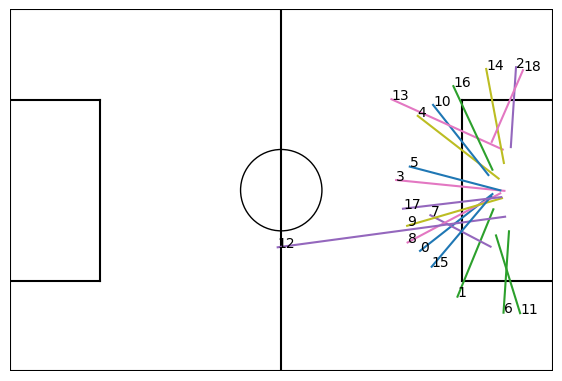

In [68]:
    # Viz centroid clusters
    plot_soccer_court()
    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.plot([aux.location_x.mean(), aux.location_x_destiny.mean()],
                 [aux.location_y.mean(), aux.location_y_destiny.mean()], i)

    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.text(aux.location_x.mean(),aux.location_y.mean(), i)

In [12]:
def cluster_viz(df,k_num,pass_type):
    
    # Get data for the clustering
    dataC = clean_data(df,pass_type)
    
    dataC_features = dataC[clusterFeatures_num]
    dataC_features = dataC_features.dropna()
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataC_features)
    
    # elbow
    inertia = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(2, 30), inertia)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method - Low Passes')
    plt.show()
    
    # Defined number of clusters
    kmeans = KMeans(n_clusters=k_num, random_state=0)
    kmeans.fit(df_scaled)
    
    # Add clusters to the data
    dataC_features['cluster'] = kmeans.labels_
    
    # Viz centroid clusters
    plot_soccer_court()
    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.plot([aux.location_x.mean(), aux.location_x_destiny.mean()],
                 [aux.location_y.mean(), aux.location_y_destiny.mean()], i)

    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.text(aux.location_x.mean(),aux.location_y.mean(), i)

    titleName = np.where(pass_type == 'high', 'High', ['Low & Ground'])[0]
    
    plt.title(titleName + ' Passes Clusters - KMeans')
    

## Cluster Plot Function

In [13]:
def plot_cluster(df, tb_df,selected_cluster, sample, ind_pass, payoff = False):
    passes = df[(df['cluster'] == selected_cluster)]
    sample = passes.sample(n=sample)
    pitch = plot_soccer_court()
    #fig, ax = pitch.draw(figsize=(8, 5))
    #fig.set_facecolor('w')
    for i in range(len(sample)):
        plt.plot([sample.location_x, sample.location_x_destiny],
                 [sample.location_y, sample.location_y_destiny], i, color = 'b')
    if payoff:
      xPayoff = np.round(tb_df[tb_df['cluster'] == selected_cluster]['payoff'].values[0], 4)
      plt.title(f'Cluster {selected_cluster} {ind_pass} passes - xPayoff {xPayoff}', color = 'k')
    else:
      plt.title(f'Cluster {selected_cluster} {ind_pass} passes', color = 'k')

## Features for clustering

In [14]:
# Define features for the clustering
#clusterFeatures_num = ['pass_angle','pass_length','pass_pass_cluster_probability',
#                           'pass_pass_success_probability','location_x','location_y',
#                           'location_x_destiny','location_y_destiny']

# Define features for the clustering
clusterFeatures_num = ['location_x','location_y',
                       'location_x_destiny','location_y_destiny',
                       'pass_angle','pass_length']

### High

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


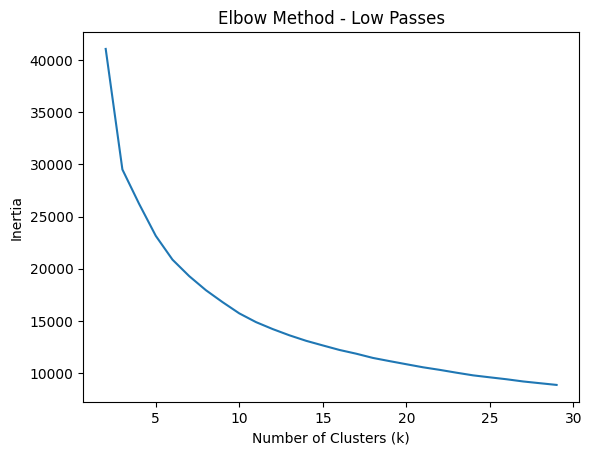

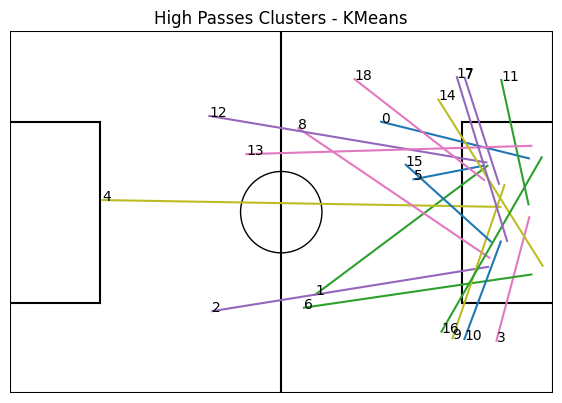

In [15]:
cluster_viz(data,20,'high')

### Low

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


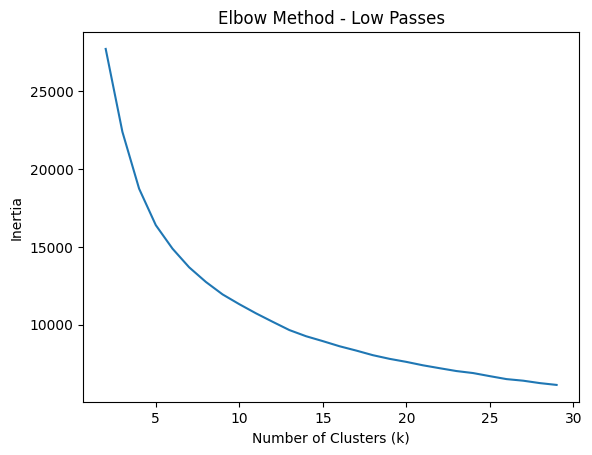

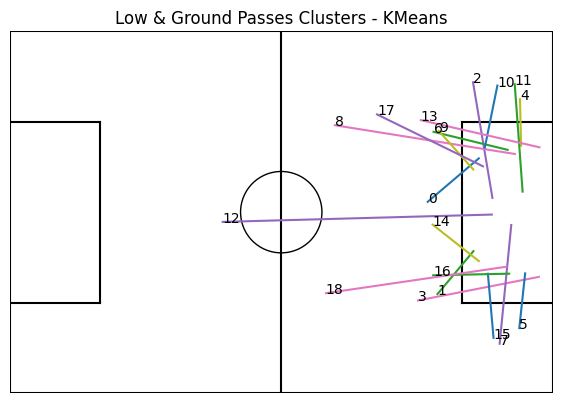

In [16]:
cluster_viz(data,20,'low')

## Cluster data frame function

Function to add the cluster label to a data frame for a certain pass type.

With the past function we can viz the clusters and the decide the optimal

In [17]:
def cluster_label(df,k_num,pass_type):
    
    # Get data for the clustering
    dataC = clean_data(df,pass_type)
    dataC = dataC.reset_index()
    dataC = dataC.drop(columns = 'level_0')
    
    dataC_features = dataC[clusterFeatures_num]
    dataC_features = dataC_features.dropna()
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataC_features)
    
    # Defined number of clusters
    kmeans = KMeans(n_clusters=k_num, random_state=0)
    kmeans.fit(df_scaled)
    
    # Add clusters to the data cleaned
    dataC_features['cluster'] = kmeans.labels_
    
    # Add cluster to the whole data if matches, if not, will be cluster -1
    data_final = dataC
    data_final = data_final.merge(dataC_features, on = clusterFeatures_num, how = 'left')
    data_final['cluster'] = np.where(data_final.cluster.isnull(),-1, data_final.cluster)
    
    return data_final, kmeans, scaler
    

In [18]:
data_high, kmeans_high, scaler_high = cluster_label(data,20,'high')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [19]:
data_low, kmeans_low, scaler_low = cluster_label(data,20,'low')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# xTreaths

In [20]:
xT = pd.read_csv('USL_xT_model.csv')

def get_start_xT_values(row):
    return xT.iloc[row['y_bin'] - 1, row['x_bin'] - 1]

def get_end_xT_values(row):
    return xT.iloc[row['end_y_bin'] - 1, row['end_x_bin'] - 1]

x_edges = np.array([  0., 6., 12., 18., 25., 32., 39., 46.,
                   53., 60., 67., 74.,  81., 88., 95., 102.,
                   108., 114., 120.])

y_edges = np.array([ 0., 6., 12., 18., 24., 30., 35., 40., 45., 50., 56.,
                   62., 68., 74., 80.])

ddf = dd.from_pandas(data, npartitions=10)
ddf = dd.from_pandas(data, npartitions=10)
ddf['x_bin'] = ddf['location_x'].apply(np.digitize, bins=x_edges)
ddf['y_bin'] = ddf['location_y'].apply(np.digitize, bins=y_edges)
ddf['end_x_bin'] = ddf['location_x_destiny'].apply(np.digitize, bins=x_edges)
ddf['end_y_bin'] = ddf['location_y_destiny'].apply(np.digitize, bins=y_edges)

# Check apply function for multiple rows
ddf['start_xT'] = ddf.apply(get_start_xT_values, axis = 1)
ddf['end_xT'] = ddf.apply(get_end_xT_values, axis = 1)

data = ddf.compute()
data['end_xT'] = np.where(data['pass_outcome'] == 'Complete', data['end_xT'], 0)
data['xT_net'] = data['end_xT'] - data['start_xT']
data['pass_outcome_num'] = data['pass_outcome'].apply(lambda x: 1 if x == 'Complete' else 0)
data.head()

counterpress  duration                                    id  index  \
0         <NA>  1.487942  a81fa116-5bb2-4417-b277-eb57315528b6      8   
1         <NA>  2.236010  3d367247-4c9c-4d00-9372-04e54b998db8     11   
2         <NA>  1.628195  abbd2a4a-b82f-42c8-b541-2a1ceae5c701     14   
3         <NA>  3.253818  6fbbe9b8-8102-4c15-8c23-c812a0b0581c     18   
4         <NA>  3.500914  6fbd2cb1-1643-4b03-b28d-d395f9bc1196     20   

      location  match_id  minute  obv_against_after  obv_against_before  \
0  [46.4 39.2]   3878996       0           0.011263            0.009849   
1  [29.7 65. ]   3878996       0           0.009855            0.011229   
2  [55.1 35.2]   3878996       0           0.010068            0.007966   
3  [81.2 40.8]   3878996       0           0.012452            0.010235   
4  [29.4 19.6]   3878996       0           0.005576            0.026442   

   obv_against_net  ...            opp_team            opp_team  x_bin  y_bin  \
0         0.001414  ...   New Mexico United   New Mexico United      8      7   
1        -0.001374  ...   New Mexico United   New Mexico United      5     12   
2         0.002102  ...   New Mexico United   New Mexico United      9      7   
3         0.002217  ...   New Mexico United   New Mexico United     13      8   
4        -0.020867  ...  Charleston Battery  Charleston Battery      5      4   

  end_x_bin end_y_bin  start_xT    end_xT    xT_net pass_outcome_num  
0         5        12  0.003645  0.001948 -0.001697                1  
1        14         7  0.001948  0.000000 -0.001948                0  
2        12         7  0.004646  0.012811  0.008165                1  
3        14        11  0.019219  0.000000 -0.019219                0  
4        14         1  0.001742  0.000000 -0.001742                0  

[5 rows x 71 columns]

### Pay Off

Add PayOff to the data

In [21]:
def get_payoff(row):
    if row['pass_outcome'] != 'Complete':
      return -row['start_xT']
    else:
      return row['xT_net']

data['payoff'] = data.apply(get_payoff, axis = 1)

## Add xT & PayOff to the High and Low data

Once xT had been calculated, add the **xT_net** and **pass_outcome_num** values to **high** and **low** passes

In [22]:
data_high = data_high.merge(data[['xT_net','pass_outcome_num', 'payoff']+clusterFeatures_num], on = clusterFeatures_num, how = 'left')

In [23]:
data_low  = data_low.merge(data[['xT_net','pass_outcome_num', 'payoff']+clusterFeatures_num], on = clusterFeatures_num, how = 'left')

### Best clusters

Get best 5 clusters for each pass types

In [24]:
tb_agg_high = data_high.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().head(5)
tb_agg_low  = data_low.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().head(5)

### Plot best clusters 

#### High

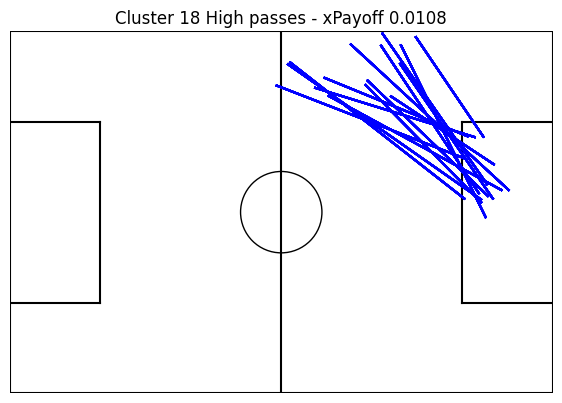

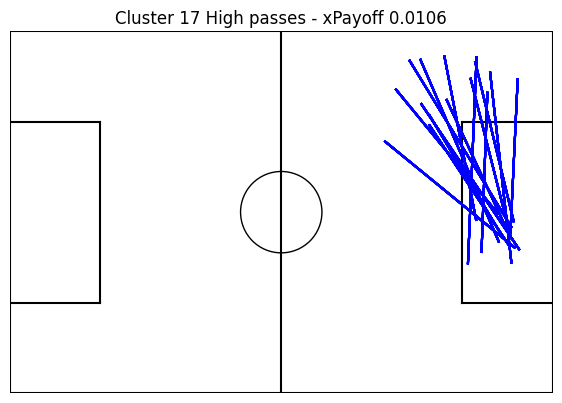

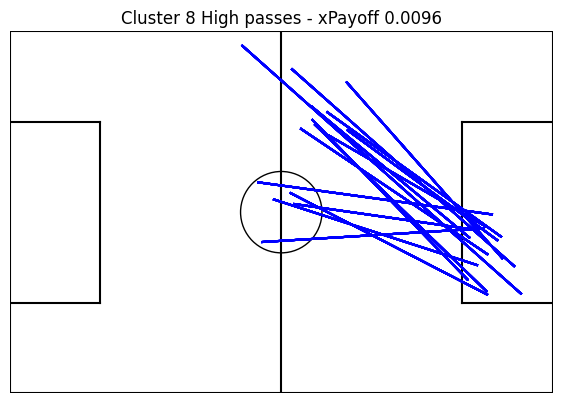

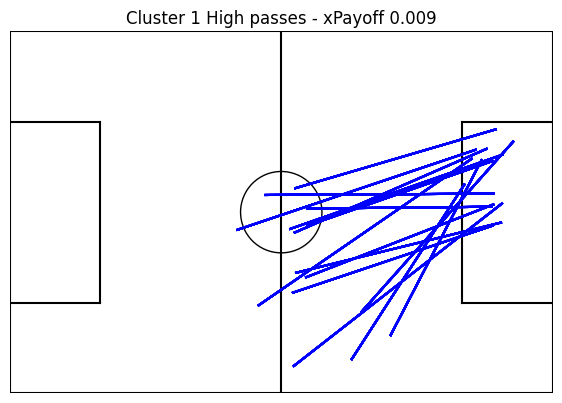

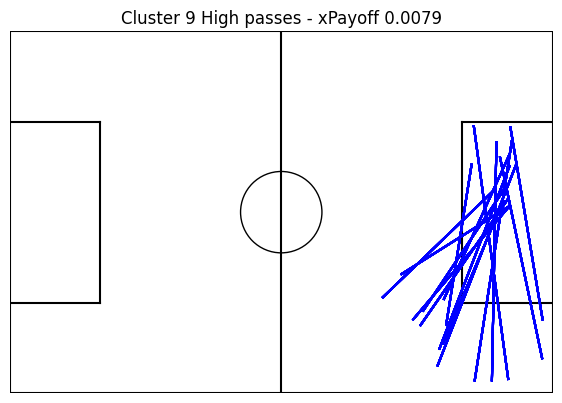

In [25]:
for cluster in tb_agg_high['cluster']:
    plot_cluster(data_high, tb_agg_high, cluster, 15, 'High', payoff = True)

#### Low & Ground

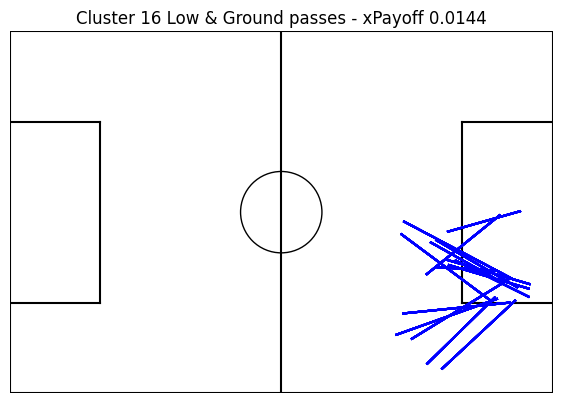

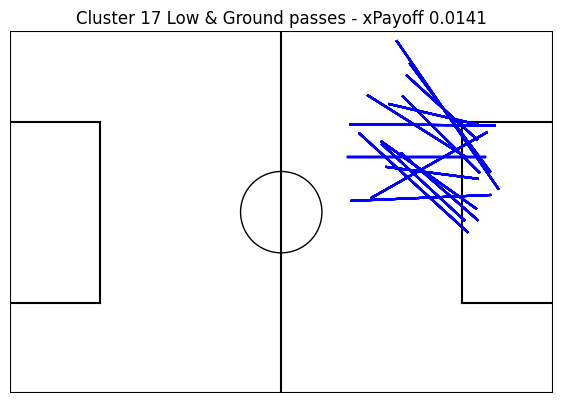

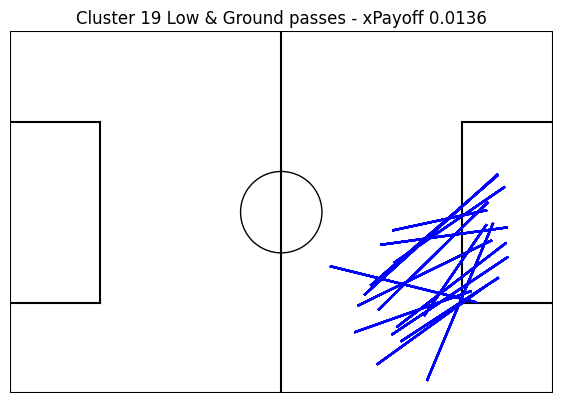

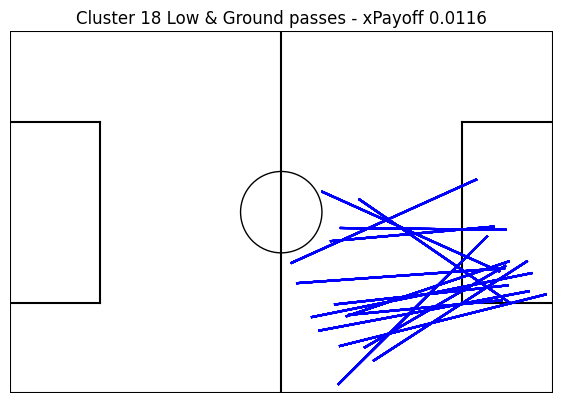

In [26]:
for cluster in tb_agg_low['cluster']:
    plot_cluster(data_low, tb_agg_low, cluster, 15, 'Low & Ground', payoff = True)

### Plot worst clusters

In [27]:
tb_agg_high_w = data_high.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().tail(5)
tb_agg_low_w  = data_low.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().tail(5)

#### High

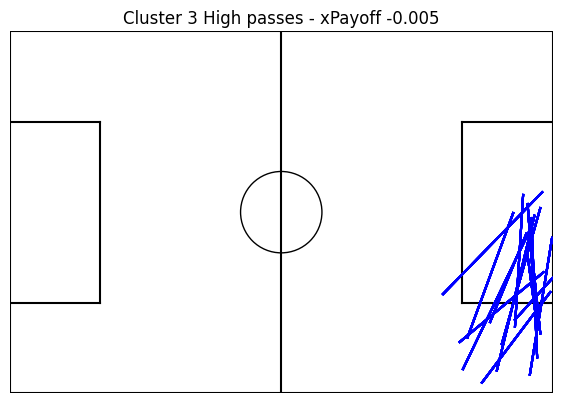

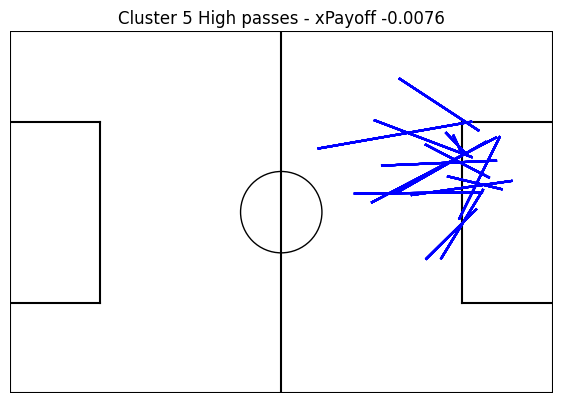

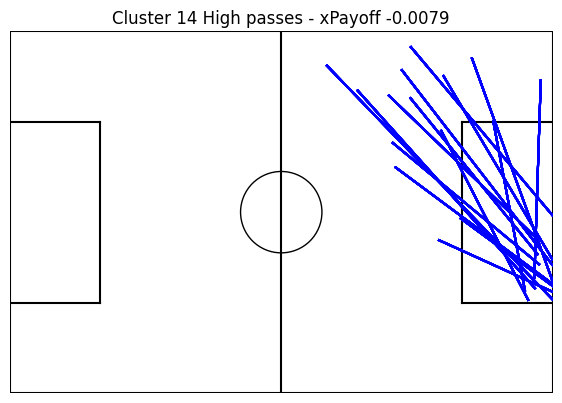

In [28]:
for cluster in tb_agg_high_w['cluster']:
    plot_cluster(data_high, tb_agg_high_w, cluster, 15, 'High',payoff = True)

#### Low & Ground

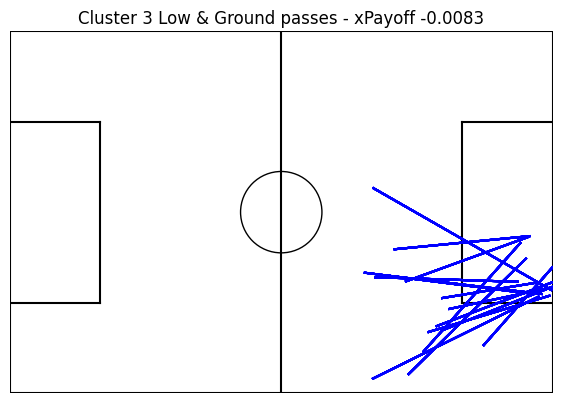

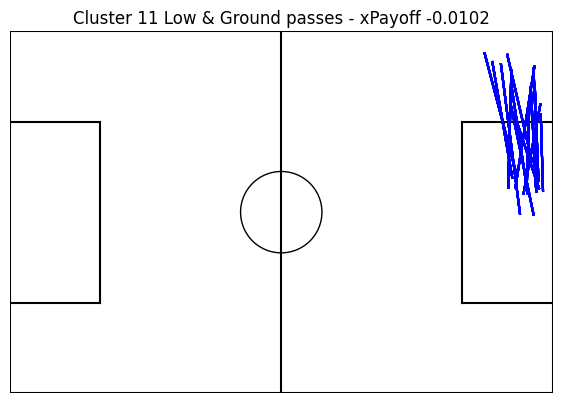

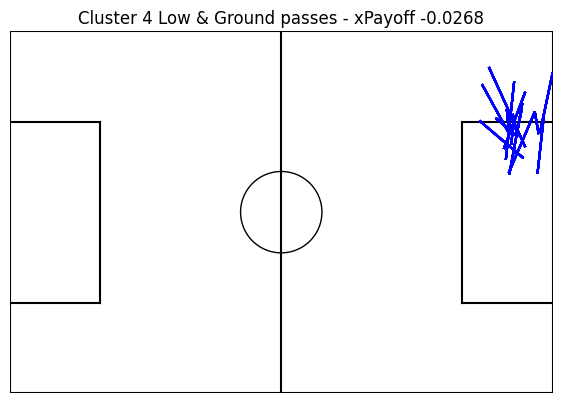

In [29]:
for cluster in tb_agg_low_w['cluster']:
    plot_cluster(data_low, tb_agg_low_w, cluster, 15, 'Low & Ground', payoff = True)

### Areas clustered - Dangerous

Top 3 clusters for High & Low passes

In [30]:
def area_clustered(df,df_agg,top_clust,ind_pass):
    best = df_agg['cluster'][top_clust-1]
    best_cluster = df[df['cluster'] == best]
    pitch = Pitch(pitch_type='statsbomb',pitch_color='w', line_color='k')
    fig, ax = pitch.draw(figsize=(8, 6))
    fig.set_facecolor('w')
    hull = pitch.convexhull(best_cluster['location_x'], best_cluster['location_y'])
    poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
    scatter = pitch.scatter(best_cluster['location_x'], best_cluster['location_y'], ax=ax, edgecolor='black', facecolor='cornflowerblue', s = 20)
    plt.title(ind_pass+' passes Area Viz - cluster: '+str(best))
    plt.show()

### High Passes

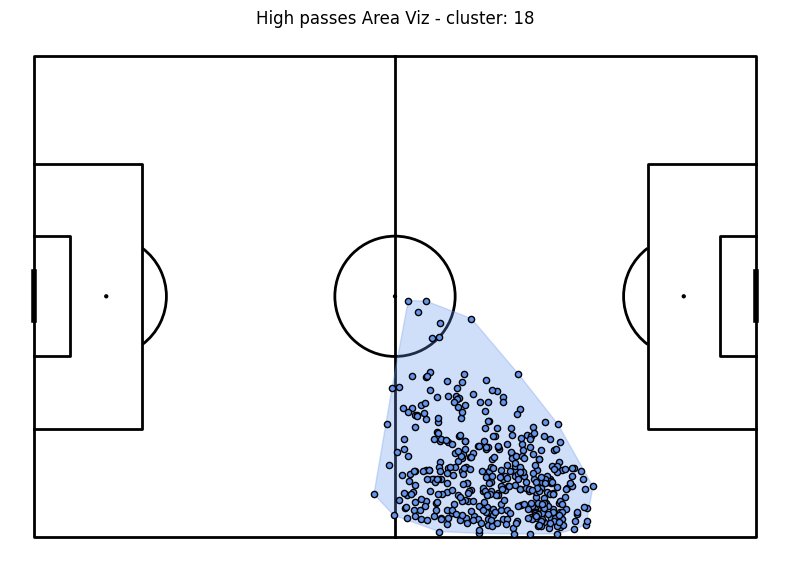

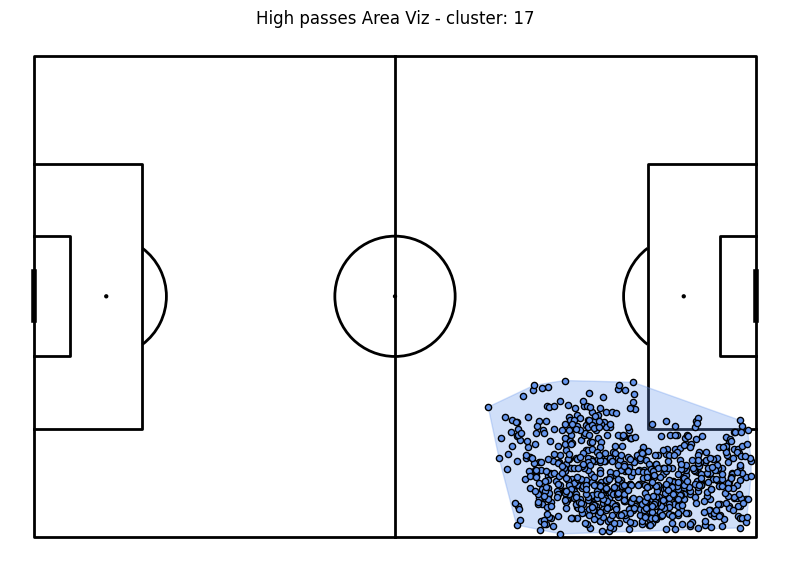

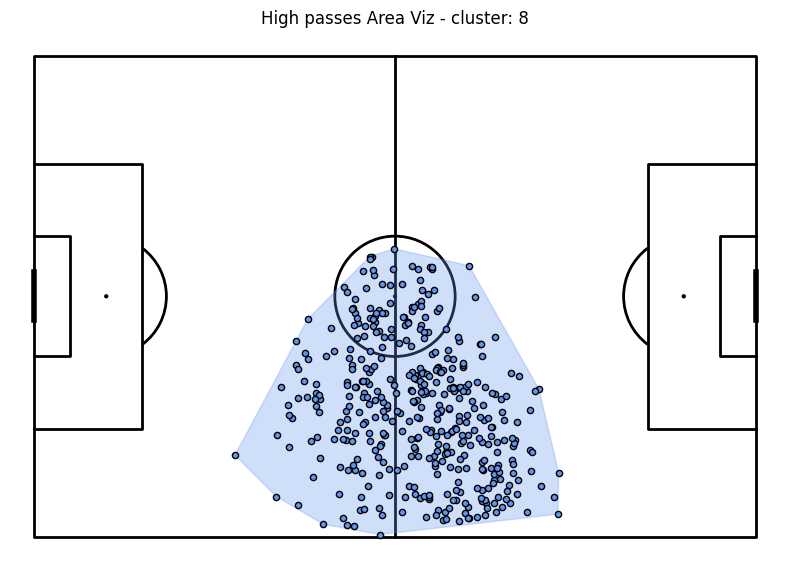

In [31]:
for cluster in range(1,4):
    area_clustered(data_high,tb_agg_high,cluster,'High')

### Low Passes

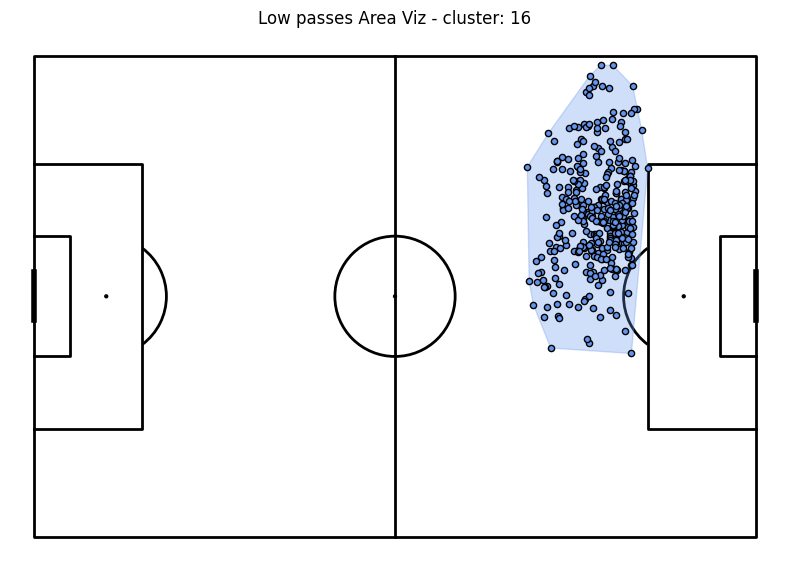

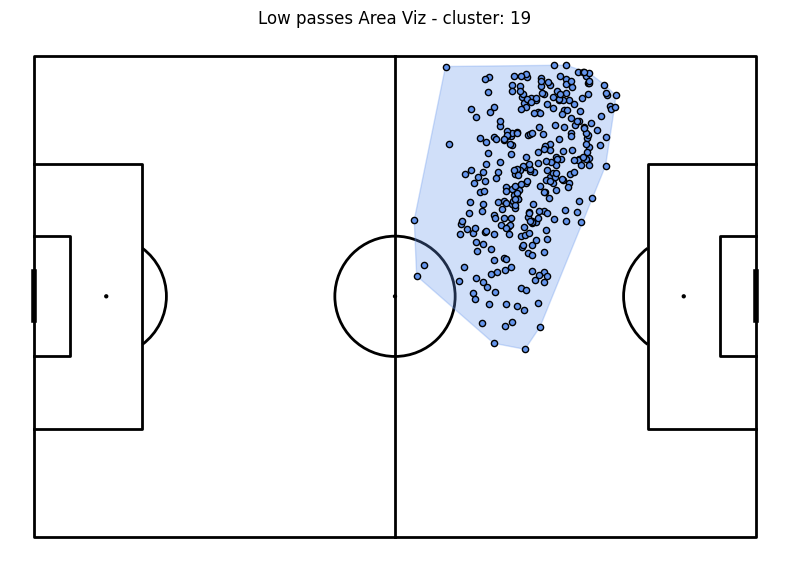

In [32]:
for cluster in range(1,4):
    area_clustered(data_low,tb_agg_low,cluster,'Low')

## Calculate xT metrics

Calculate xT metrics:
 - total_xT
 - avg_xT
 - atempts
 - succes_rate

And add if the pass was:
 - Left
 - Right
 - Center

In [33]:
def get_channel(row):
  if row['location_y'] <= 27:
    return 'left'
  elif row['location_y'] >= 53:
    return 'right'
  else:
    return 'center'

In [34]:
def xT_metrics(data):
    bu = data[data['location_x'] <= 120/3]
    bu['channel'] = bu.apply(get_channel, axis = 1)
    bu_agg = bu.groupby(['team', 'channel']).agg(
        total_xT=('xT_net', 'sum'),
        avg_xT=('xT_net', 'mean'),
        attempts=('xT_net', 'count'),
        success_rate=('pass_outcome_num', 'mean')).reset_index()
    return bu_agg

In [35]:
data_high_bu_agg = xT_metrics(data_high)
data_low_bu_agg  = xT_metrics(data_low)

In [36]:
data_high_bu_agg.sort_values(['avg_xT'], ascending = False).head(10)

team channel  total_xT    avg_xT  attempts  success_rate
28       Loudoun United    left  0.031017  0.031017         1      1.000000
31      Louisville City    left  0.125457  0.020910         6      0.333333
13   El Paso Locomotive    left  0.123402  0.020567         6      0.166667
14   El Paso Locomotive   right  0.121231  0.015154         8      0.375000
46     Oakland Roots SC    left  0.044615  0.014872         3      0.333333
59  Sacramento Republic  center  0.086579  0.014430         6      0.166667
26     Las Vegas Lights   right  0.036824  0.012275         3      0.333333
52       Phoenix Rising   right  0.052692  0.008782         6      0.166667
12   El Paso Locomotive  center  0.134837  0.008427        16      0.125000
62          San Antonio  center  0.155916  0.007425        21      0.142857

In [37]:
data_low_bu_agg.sort_values(['avg_xT'], ascending = False).head(10)

team channel  total_xT    avg_xT  attempts  success_rate
7    New Mexico United   right  0.057621  0.057621         1           1.0
1   El Paso Locomotive   right -0.001964 -0.001964         1           0.0
4       Loudoun United   right -0.001964 -0.001964         1           0.0
5          Memphis 901  center -0.004055 -0.002028         2           0.0
2             FC Tulsa  center -0.002372 -0.002372         1           0.0
3          Indy Eleven   right -0.002372 -0.002372         1           0.0
11     San Diego Loyal  center -0.002372 -0.002372         1           0.0
8     Oakland Roots SC   right -0.002454 -0.002454         1           0.0
6    New Mexico United    left -0.002695 -0.002695         1           0.0
0         Detroit City    left -0.002714 -0.002714         1           0.0

### By pass Cluster

In [38]:
def xT_metrics_cluster(data):
    bu = data[data['location_x'] <= 120/3]
    bu['channel'] = bu.apply(get_channel, axis = 1)
    bu_agg = bu.groupby(['team', 'channel','cluster']).agg(
        total_xT=('xT_net', 'sum'),
        avg_xT=('xT_net', 'mean'),
        attempts=('xT_net', 'count'),
        success_rate=('pass_outcome_num', 'mean')).reset_index()
    return bu_agg

In [39]:
data_high_bu_agg_clus = xT_metrics_cluster(data_high)
data_low_bu_agg_clus  = xT_metrics_cluster(data_low)

Top 5 per cluster for High

In [40]:
grouped = data_high_bu_agg_clus[data_high_bu_agg_clus.cluster != -1].groupby('cluster')

# Calculate dense rank of 'avg_xT' within each group
data_high_bu_agg_clus['ranked'] = grouped['avg_xT'].transform(lambda x: x.rank(ascending=False, method='dense'))

data_high_bu_agg_clus[data_high_bu_agg_clus['ranked'] <= 5].drop('ranked', axis=1).sort_values(['cluster','avg_xT'])

team channel  cluster  total_xT    avg_xT  attempts  \
23             Detroit City    left        2  0.041549  0.020774         2   
98        New Mexico United  center        2  0.044574  0.022287         2   
107        Oakland Roots SC    left        2  0.045904  0.022952         2   
68           Loudoun United    left        2  0.031017  0.031017         1   
6        Charleston Battery  center        2  0.061504  0.061504         1   
141     Sacramento Republic  center        4  0.089685  0.017937         5   
63         Las Vegas Lights   right        4  0.039305  0.019652         2   
110        Orange County SC  center        4  0.056497  0.028248         2   
76          Louisville City    left        4  0.072760  0.036380         2   
32       El Paso Locomotive    left        4  0.129121  0.043040         3   
128  Pittsburgh Riverhounds    left        6 -0.002150 -0.002150         1   
162       Tampa Bay Rowdies    left        6 -0.002032 -0.002032         1   
40                 FC Tulsa    left        6 -0.001887 -0.001887         1   
144     Sacramento Republic   right        8 -0.002363 -0.002363         1   
35       El Paso Locomotive   right       12  0.082289  0.020572         4   
30       El Paso Locomotive  center       12  0.055133  0.027567         2   
115        Orange County SC    left       12  0.033107  0.033107         1   
45        Hartford Athletic  center       12  0.041382  0.041382         1   
77          Louisville City    left       12  0.057919  0.057919         1   
16         Colorado Springs  center       13 -0.006930 -0.002310         3   
46        Hartford Athletic  center       13 -0.002193 -0.002193         1   
2         Birmingham Legion  center       13 -0.002150 -0.002150         1   
112        Orange County SC  center       13 -0.002150 -0.002150         1   
119          Phoenix Rising  center       13 -0.001981 -0.001981         1   
124          Phoenix Rising   right       13  0.061281  0.030640         2   

     success_rate  
23       0.500000  
98       0.500000  
107      0.500000  
68       1.000000  
6        1.000000  
141      0.200000  
63       0.500000  
110      0.500000  
76       0.500000  
32       0.333333  
128      0.000000  
162      0.000000  
40       0.000000  
144      0.000000  
35       0.500000  
30       0.500000  
115      1.000000  
45       1.000000  
77       1.000000  
16       0.000000  
46       0.000000  
2        0.000000  
112      0.000000  
119      0.000000  
124      0.500000

Top 5 cluster per Low

In [41]:
grouped = data_low_bu_agg_clus[data_low_bu_agg_clus.cluster != -1].groupby('cluster')

# Calculate dense rank of 'avg_xT' within each group
data_low_bu_agg_clus['ranked'] = grouped['avg_xT'].transform(lambda x: x.rank(ascending=False, method='dense'))

data_low_bu_agg_clus[data_low_bu_agg_clus['ranked'] <= 5].drop('ranked', axis=1).sort_values(['cluster','avg_xT'])

team channel  cluster  total_xT    avg_xT  attempts  \
8     Oakland Roots SC   right       12 -0.002454 -0.002454         1   
2             FC Tulsa  center       12 -0.002372 -0.002372         1   
3          Indy Eleven   right       12 -0.002372 -0.002372         1   
11     San Diego Loyal  center       12 -0.002372 -0.002372         1   
5          Memphis 901  center       12 -0.004055 -0.002028         2   
1   El Paso Locomotive   right       12 -0.001964 -0.001964         1   
4       Loudoun United   right       12 -0.001964 -0.001964         1   
7    New Mexico United   right       12  0.057621  0.057621         1   

    success_rate  
8            0.0  
2            0.0  
3            0.0  
11           0.0  
5            0.0  
1            0.0  
4            0.0  
7            1.0

## Grouped by OR

Grouped top

In [42]:
def grouped(df, by):
  result_sorted = df.sort_values(by=['channel', by], ascending=[True, False])
  result_sorted['rank'] = result_sorted.groupby('channel').cumcount() + 1
  return result_sorted[result_sorted['team'] == 'Oakland Roots SC' ][['team', 'channel', by, 'rank']]

High Passes

In [43]:
print(grouped(data_high_bu_agg_clus, 'total_xT'))
print(grouped(data_high_bu_agg_clus, 'avg_xT'))
print(grouped(data_high_bu_agg_clus, 'attempts'))
print(grouped(data_high_bu_agg_clus, 'success_rate'))

                 team channel  total_xT  rank
106  Oakland Roots SC  center -0.002469    27
105  Oakland Roots SC  center -0.020179    65
107  Oakland Roots SC    left  0.045904     4
108  Oakland Roots SC    left -0.001289    13
                 team channel    avg_xT  rank
105  Oakland Roots SC  center -0.002018    21
106  Oakland Roots SC  center -0.002469    55
107  Oakland Roots SC    left  0.022952     6
108  Oakland Roots SC    left -0.001289    16
                 team channel  attempts  rank
105  Oakland Roots SC  center        10     6
106  Oakland Roots SC  center         1    60
107  Oakland Roots SC    left         2    27
108  Oakland Roots SC    left         1    42
                 team channel  success_rate  rank
105  Oakland Roots SC  center           0.0    49
106  Oakland Roots SC  center           0.0    50
107  Oakland Roots SC    left           0.5     6
108  Oakland Roots SC    left           0.0    32


Low Passes

In [44]:
print(grouped(data_low_bu_agg_clus, 'total_xT'))
print(grouped(data_low_bu_agg_clus, 'avg_xT'))
print(grouped(data_low_bu_agg_clus, 'attempts'))
print(grouped(data_low_bu_agg_clus, 'success_rate'))

               team channel  total_xT  rank
8  Oakland Roots SC   right -0.002454     5
               team channel    avg_xT  rank
8  Oakland Roots SC   right -0.002454     5
               team channel  attempts  rank
8  Oakland Roots SC   right         1     5
               team channel  success_rate  rank
8  Oakland Roots SC   right           0.0     5


Grouped with cluster

Gruoped top

In [45]:
def grouped_clus(df, by):
    df = df[df.cluster != -1]
    result_sorted = df.sort_values(by=['channel', by, 'cluster'], ascending=[True, False, True])
    result_sorted['rank'] = result_sorted.groupby(['channel','cluster']).cumcount() + 1
    return result_sorted[result_sorted['team'] == 'Oakland Roots SC' ][['team', 'channel', by, 'cluster','rank']]

High Passes

In [46]:
print(grouped_clus(data_high_bu_agg_clus, 'total_xT'))
print(grouped_clus(data_high_bu_agg_clus, 'avg_xT'))
print(grouped_clus(data_high_bu_agg_clus, 'attempts'))
print(grouped_clus(data_high_bu_agg_clus, 'success_rate'))

                 team channel  total_xT  cluster  rank
106  Oakland Roots SC  center -0.002469       12     7
105  Oakland Roots SC  center -0.020179        4    23
107  Oakland Roots SC    left  0.045904        2     1
108  Oakland Roots SC    left -0.001289        4     6
                 team channel    avg_xT  cluster  rank
105  Oakland Roots SC  center -0.002018        4    14
106  Oakland Roots SC  center -0.002469       12    14
107  Oakland Roots SC    left  0.022952        2     2
108  Oakland Roots SC    left -0.001289        4     9
                 team channel  attempts  cluster  rank
105  Oakland Roots SC  center        10        4     6
106  Oakland Roots SC  center         1       12    15
107  Oakland Roots SC    left         2        2    19
108  Oakland Roots SC    left         1        4    15
                 team channel  success_rate  cluster  rank
105  Oakland Roots SC  center           0.0        4    20
106  Oakland Roots SC  center           0.0       12    1

Low Passes

In [47]:
print(grouped_clus(data_low_bu_agg_clus, 'total_xT'))
print(grouped_clus(data_low_bu_agg_clus, 'avg_xT'))
print(grouped_clus(data_low_bu_agg_clus, 'attempts'))
print(grouped_clus(data_low_bu_agg_clus, 'success_rate'))

               team channel  total_xT  cluster  rank
8  Oakland Roots SC   right -0.002454       12     5
               team channel    avg_xT  cluster  rank
8  Oakland Roots SC   right -0.002454       12     5
               team channel  attempts  cluster  rank
8  Oakland Roots SC   right         1       12     5
               team channel  success_rate  cluster  rank
8  Oakland Roots SC   right           0.0       12     5
